# Prototype du jeu NIM

### NIM game where 2 llm's can battle each other (and humans as well)

Try to display n matchsticks

In [72]:
# Import libraries
from IPython.display import HTML, SVG, display
from dotenv import load_dotenv
from openai import OpenAI
import json

In [73]:
load_dotenv(override=True)

True

In [74]:
MATCHSTICKS_SVG_PATH = "assets/matchstick.svg"

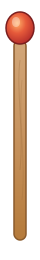

In [20]:
# Show 5 matchsticks

display(SVG(filename=MATCHSTICKS_SVG_PATH))

In [21]:
# Test simple, display 5 matchsticks
def display_matchsticks(n=5, height=140, gap=0):
    html = "<div style='display: flex; align-items: center;'>"
    
    for _ in range(n):
        html += f"""
        <img src="{MATCHSTICKS_SVG_PATH}"
             style="
                height: {height}px;
                margin-right: {gap}px;
             ">
        """
    
    html += "</div>"
    display(HTML(html))



In [22]:
display_matchsticks(n=5)

Manage the game

In [27]:
# Some constants

RED = 1
YELLOW = 2
EMPTY = 0

In [67]:
# The Nim game implementation

class NimGame:
    def __init__(self, variant="normal", n = 21):
        # variant can be "normal" or "a" or "b"
        self.variant = variant
        self.n = n  # Number of matchsticks
        self.history = []
        self.winner = EMPTY
        self.player_to_move = RED  # RED starts
        
    def __repr__(self):
        self.display_matchsticks(n=self.n)
        
        if self.winner:
            return f"Le joueur {'Rouge' if self.winner == RED else 'Jaune'} a gagné!"
        else:
            return f"Il reste {self.n} bâtonnets. C'est au joueur {'Rouge' if self.player_to_move == RED else 'Jaune'} de jouer."

    def pick(self, taken):
        # Check if move is valid
        if taken not in self.valid_moves():
            raise ValueError(f"Invalid move: {taken}. Valid moves are: {self.valid_moves()}")
        
        self.n -= taken
        self.history.append(taken)
        self.player_to_move = YELLOW if self.player_to_move == RED else RED
    
    def valid_moves(self):
        # Version de base:
        # -Chaque joueur a la possibilité de piger 1 ou 2 baguette

        # Variante A:
        # -Si le nombre de baguettes restant est pair, le joueur peut retirer 1, 2 ou 4 baguettes. Si le nombre de baguettes est impair, le joueur peut retirer 1, 3 ou 4 baguettes 

        # Variante B:
        # -Chaque joueur a la possibilité de piger 1, 2 ou 3 baguettes. Il ne peut pas y avoir 2 tours consécutifs où le meme nombre de baguette est retiré.
        valid_moves = []
        if self.variant == "normal":
            valid_moves = [1, 2]
        elif self.variant == "a":
            if self.n % 2 == 0:
                valid_moves = [1, 2, 4]
            else:
                valid_moves = [1, 3, 4]
        elif self.variant == "b":
            last_move = self.history[-1] if self.history else None
            for move in [1, 2, 3]:
                if move != last_move:
                    valid_moves.append(move)
                    
        return [move for move in valid_moves if move <= self.n]
    
    def display_matchsticks(self, n=5, height=140):
        html = "<div style='display: flex; align-items: center;'>"
        
        for i in range(n):
            # every 5 matchsticks, add a small gap
            gap = height/7 if (i + 1) > 0 and (i + 1) % 5 == 0 else 0
            html += f"""
            <img src="{MATCHSTICKS_SVG_PATH}"
                style="
                    height: {height}px;
                    margin-right: {gap}px;
                ">
            """
        
        html += "</div>"
        display(HTML(html))
        
    def check_winner(self):
        if self.n == 0:
            if self.variant == "normal":
                self.winner = YELLOW if self.player_to_move == RED else RED
            else:  # misère
                self.winner = self.player_to_move
        return self.winner
            


In [51]:
# Test the NimGame class
g = NimGame("normal")
g.player_move(1)
g.player_move(2)
g.player_move(2)
g.player_move(1)
g

Il reste 15 bâtonnets. C'est au joueur Rouge de jouer.

In [52]:
g.history

[1, 2, 2, 1]

Define a model Player that calls the LLM

In [77]:
class Player:
    def __init__(self, model, color):
        self.model = model
        self.color = color
        self.llm = OpenAI()
        
    def system(self, nim_game):
        legal_moves_str = ", ".join(map(str, nim_game.valid_moves()))
        prompt = f"""You are an expert player in the game of Nim.
There is a single pile of sticks. On your turn, you must remove between {legal_moves_str} sticks.
You MUST remove at least 1 stick.
The player who takes the LAST stick WINS.
You play optimally and rationally to maximize your chance of winning.
You should respond in JSON, and only in JSON, according to this spec:

{{
    "evaluation": "brief assessment of the current game state",
    "threats": "any immediate risks if you play poorly",
    "opportunities": "any winning patterns or advantages in the current position",
    "strategy": "concise reasoning behind the chosen move",
    "move_remove": "number of sticks to remove, must be one of: {legal_moves_str}"
}}
"""
        return prompt
    
    def user(self, nim_game):
        legal_moves_str = ", ".join(map(str, nim_game.valid_moves()))
        prompt = f"""It is your turn to play. Choose your move. 
There are {nim_game.n} sticks remaining.

Now with this in mind, make your decision. Respond only in JSON strictly according to this spec:
{{
    "evaluation": "brief assessment of the current game state",
    "threats": "any immediate risks if you play poorly",
    "opportunities": "any winning patterns or advantages in the current position",
    "strategy": "concise reasoning behind the chosen move",
    "move_remove": "number of sticks to remove, must be one of: {legal_moves_str}"
}}

You must remove a number of sticks from the pile between {legal_moves_str}.
"""
        return prompt
    
    def pick(self, nim_game):
        system_prompt = self.system(nim_game)
        user_prompt = self.user(nim_game)
        
        response = self.llm.chat.completions.create(
            model=self.model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            response_format={"type": "json_object"}
        )
        
        content = response.choices[0].message.content
        
        self.process_move(content, nim_game)
        
    def process_move(self, response, nim_game):
        print(response)
        try:
            result = json.loads(response)
            move_remove = int(result.get("move_remove"))
            
            # Check if move is valid
            if move_remove not in nim_game.valid_moves():
                raise ValueError(f"Invalid move: {move_remove}")
            nim_game.pick(move_remove)
        except Exception as e:
            print(f"Exception {e}")
            # If invalid, set user who just played as loser
            nim_game.winner = YELLOW if self.color == RED else RED
            
        


In [78]:
# Try
game = NimGame(variant="normal")
player_red = Player(model="gpt-4o-mini", color=RED)
player_yellow = Player(model="gpt-4o-mini", color=YELLOW)

In [79]:
player_red.pick(game)
print(f"Winner: {game.winner}")

{
    "evaluation": "There are 21 sticks remaining, which is a favorable position for the first player.",
    "threats": "If I play poorly and remove only 1 stick, my opponent may have a winning response.",
    "opportunities": "Removing 1 stick will leave 20 sticks, which is a losing position for the opponent when I play optimally.",
    "strategy": "To maximize my chances of winning, I will remove 1 stick, leaving the opponent with 20 sticks and maintaining an advantageous position.",
    "move_remove": 1
}
Winner: 0


In [80]:
game

Il reste 20 bâtonnets. C'est au joueur Jaune de jouer.

In [81]:
player_yellow.pick(game)
print(f"Winner: {game.winner}")

{
    "evaluation": "There are 20 sticks remaining, a substantial number in the game.",
    "threats": "If I leave 19 or 18 sticks, my opponent can respond optimally.",
    "opportunities": "I can manipulate the pile down to a favorable number for me.",
    "strategy": "Removing 2 sticks leaves 18, allowing me to control the pace of the game.",
    "move_remove": 2
}
Winner: 0


In [82]:
while not game.winner:
    player_red.pick(game)
    if not game.winner:
        player_yellow.pick(game)
        
print(f"Winner: {game.winner}")
game


{
    "evaluation": "There are 18 sticks remaining, giving the first player a possible advantage.",
    "threats": "If I leave 17 sticks, my opponent can leave me with a losing position by reducing it to 15, depending on their move.",
    "opportunities": "I can remove 2 sticks to leave 16 for the opponent, ensuring I can control the flow of the game.",
    "strategy": "Removing 2 sticks is optimal as it creates a more favorable position for me by keeping the number of sticks even, making it harder for my opponent to win.",
    "move_remove": 2
}
{
    "evaluation": "There are 16 sticks remaining, which is an even number and within a favorable range.",
    "threats": "If I do not play optimally, my opponent can adopt a winning strategy.",
    "opportunities": "By maintaining control and leaving an odd number of sticks, I can force my opponent into a disadvantageous position.",
    "strategy": "To ensure I control the game, I should remove 2 sticks, leaving 14 sticks for my opponent.",


Le joueur Rouge a gagné!